# Custom PyTorch Dataset using Imagenette

For a smaller version of Imagenet that I can use on my home computer, I used Imagenette from the [FastAI repo](https://github.com/fastai/imagenette). Below is some information from the repo.

> Imagenette is a subset of 10 easily classified classes from Imagenet (tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute).
>
> The dataset also comes with a CSV file with 1%, 5%, 25%, and 50% of the labels randomly changed to an incorrect label. More information about the noisy labels are provided in the "noisy_labels" folder. Leaderboards for 5% noise and 50% noise are maintained below.

This notebook shows how to make a custom PyTorch `Dataset` and how to use the `DataLoader`. If your dataset is organized in a simple way (see below) without any customizations, you may be able to use `dataset.ImageFolder` rather than write a custom `Dataset` [[link]](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#afterword-torchvision) 

```
root/ants/xxx.png
root/ants/xxy.jpeg
root/ants/xxz.png
.
.
.
root/bees/123.jpg
root/bees/nsdf3.png
root/bees/asd932_.png
```

### Useful Resources
- PyTorch [Datasets & Dataloaders overview](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
- PyTorch [Writing Custom Datasets, Dataloaders, and Transforms](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)


In [6]:
import os
import numpy as np
import pandas as pd
from skimage import io, transform
import matplotlib.pyplot as plt
from PIL import Image
import random

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.io import read_image

In [4]:
%matplotlib inline

In [53]:
torch.manual_seed(17)
np.random.seed(17)

## Explore Imagenette Dataset

In [8]:
# set this location to where you extracted the Imagenette datset
datadir = "../../datasets/imagenette2"

In [9]:
images_df = pd.read_csv(os.path.join(datadir, "noisy_imagenette.csv"))

In [10]:
images_df

path noisy_labels_0  \
0               train/n02979186/n02979186_9036.JPEG      n02979186   
1              train/n02979186/n02979186_11957.JPEG      n02979186   
2               train/n02979186/n02979186_9715.JPEG      n02979186   
3              train/n02979186/n02979186_21736.JPEG      n02979186   
4      train/n02979186/ILSVRC2012_val_00046953.JPEG      n02979186   
...                                             ...            ...   
13389            val/n03425413/n03425413_17521.JPEG      n03425413   
13390            val/n03425413/n03425413_20711.JPEG      n03425413   
13391            val/n03425413/n03425413_19050.JPEG      n03425413   
13392            val/n03425413/n03425413_13831.JPEG      n03425413   
13393             val/n03425413/n03425413_1242.JPEG      n03425413   

      noisy_labels_1 noisy_labels_5 noisy_labels_25 noisy_labels_50  is_valid  
0          n02979186      n02979186       n02979186       n02979186     False  
1          n02979186      n02979186       n02979186       n03000684     False  
2          n02979186      n02979186       n03417042       n03000684     False  
3          n02979186      n02979186       n02979186       n03417042     False  
4          n02979186      n02979186       n02979186       n03394916     False  
...              ...            ...             ...             ...       ...  
13389      n03425413      n03425413       n03425413       n03425413      True  
13390      n03425413      n03425413       n03425413       n03425413      True  
13391      n03425413      n03425413       n03425413       n03425413      True  
13392      n03425413      n03425413       n03425413       n03425413      True  
13393      n03425413      n03425413       n03425413       n03425413      True  

[13394 rows x 7 columns]

In [11]:
labels = pd.unique(images_df['noisy_labels_0'])
print(labels, len(labels))

['n02979186' 'n03417042' 'n01440764' 'n02102040' 'n03028079' 'n03888257'
 'n03394916' 'n03000684' 'n03445777' 'n03425413'] 10


In [12]:
images_df['is_valid']==True

0        False
1        False
2        False
3        False
4        False
         ...  
13389     True
13390     True
13391     True
13392     True
13393     True
Name: is_valid, Length: 13394, dtype: bool

In [13]:
images_df['path'].iloc[3]

'train/n02979186/n02979186_21736.JPEG'

In [14]:
# This set correspond to the new 70/30 train/valid split (released in Dec 6 2019).
n_valid = images_df['is_valid'].sum()
n_train = len(images_df) - n_valid
print(f"Training set has {n_train} samples. \nValidation set has {n_valid} samples.")

Training set has 9469 samples. 
Validation set has 3925 samples.


In [42]:
# Explore class distribution 
image_sample_dict = {}
first_img_per_class = []
for label in labels:
    class_samples = images_df['path'][images_df['noisy_labels_0']==label]
    print(f"Class {label} has {len(class_samples)} samples")
    image_sample_dict[label] = class_samples.iloc[0]
    first_img_per_class.append(class_samples.index.tolist()[0])

Class n02979186 has 1350 samples
Class n03417042 has 1350 samples
Class n01440764 has 1350 samples
Class n02102040 has 1350 samples
Class n03028079 has 1350 samples
Class n03888257 has 1350 samples
Class n03394916 has 1350 samples
Class n03000684 has 1244 samples
Class n03445777 has 1350 samples
Class n03425413 has 1350 samples


In [16]:
image_sample_dict

{'n02979186': 'train/n02979186/n02979186_9036.JPEG',
 'n03417042': 'train/n03417042/n03417042_5004.JPEG',
 'n01440764': 'train/n01440764/n01440764_7963.JPEG',
 'n02102040': 'train/n02102040/n02102040_3183.JPEG',
 'n03028079': 'train/n03028079/n03028079_53734.JPEG',
 'n03888257': 'train/n03888257/n03888257_45616.JPEG',
 'n03394916': 'train/n03394916/n03394916_29217.JPEG',
 'n03000684': 'train/n03000684/n03000684_22664.JPEG',
 'n03445777': 'train/n03445777/n03445777_4097.JPEG',
 'n03425413': 'train/n03425413/n03425413_13746.JPEG'}

In [17]:
labels_map = {
    'n02979186': 'cassette player',
    'n03417042': 'garbage truck',
    'n01440764': 'tench (fish)',
    'n02102040': 'English springer',
    'n03028079': 'church',
    'n03888257': 'parachute',
    'n03394916': 'French horn',
    'n03000684': 'chain saw',
    'n03445777': 'golf ball',
    'n03425413': 'gas pump'
}

In [18]:
labels_num_map = {
    'n02979186': 0,
    'n03417042': 1,
    'n01440764': 2,
    'n02102040': 3,
    'n03028079': 4,
    'n03888257': 5,
    'n03394916': 6,
    'n03000684': 7,
    'n03445777': 8,
    'n03425413': 9
}

In [19]:
num_labels_map = {v: labels_map[k] for k, v in labels_num_map.items()}

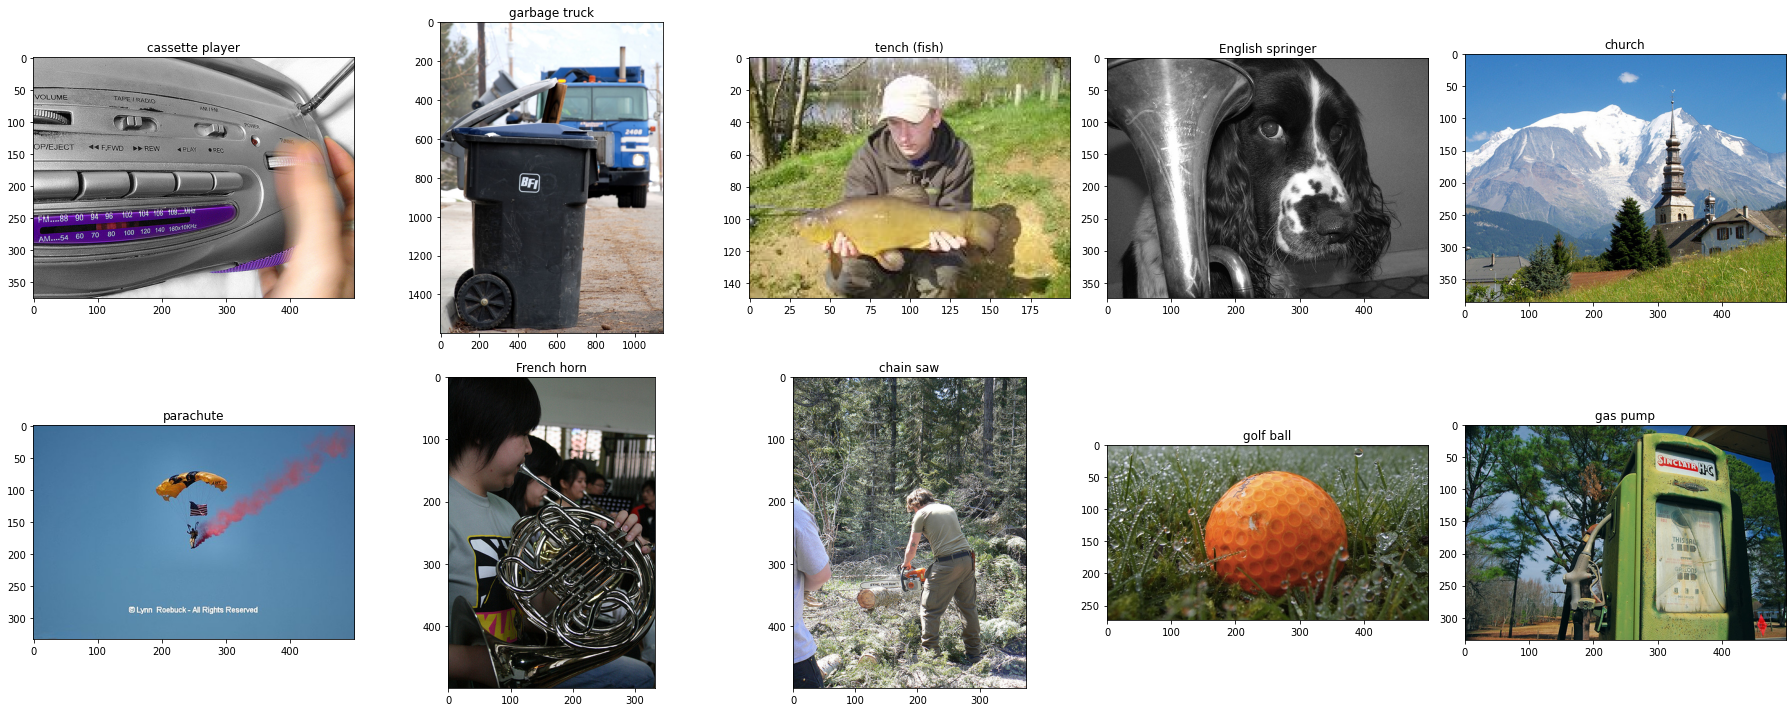

In [20]:
# visualize first sample of each class
w, h, size = 5, 2, 5
fig, axs = plt.subplots(h, w, figsize=(w*size, h*size))
axs = axs.ravel()
images = []

for i, (name, fn) in enumerate(image_sample_dict.items()):
    img = io.imread(os.path.join(datadir, fn), as_gray=False)
    
    # if grayscale, expand to 3 dims
    if img.ndim < 3:
        img = np.stack([img]*3, axis=-1)
        
    images.append(img)
    axs[i].imshow(img)
    axs[i].set_title(labels_map[name])
plt.tight_layout()
plt.show()

## Build Custom Class

In [21]:
IMAGENET_RGB_MEANS = [0.485, 0.456, 0.406]
IMAGENET_RGB_STDS = [0.229, 0.224, 0.225]

In [49]:
class ImagenetteDataset(Dataset):
    def __init__(
        self, 
        root_dir: str, 
        csv_filename: str = "noisy_imagenette.csv",
        train: bool = True,
        noisy_perc: int = 0,
        transform = None,
        target_transform = None,
    ):
        
        csv_data = pd.read_csv(os.path.join(root_dir, csv_filename))
        self.img_paths, self.labels = self.get_dataset(csv_data, train, noisy_perc)
        self.root_dir = root_dir
        
        self.transform = transform
        self.target_transform = target_transform

    def get_dataset(self, csv_data, train, noisy_perc):
        if train:
            data = csv_data[csv_data['is_valid'] == False]
        else:
            data = csv_data[csv_data['is_valid'] == True]
        
        if noisy_perc not in [0,1,5,25,50]:
            raise ValueError(f'{noisy_perc} not a valid noisy label percentage. Select: 0,1,5,25,50')
        
        labels = data[f'noisy_labels_{noisy_perc}']
        labels = labels.replace(labels_num_map)
        img_paths = data['path']
        return img_paths, labels
        

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        # open image as torch tensor
        img_path = os.path.join(self.root_dir, self.img_paths.iloc[idx])
        image = read_image(img_path) # reads image into torch format (C, H, W)

        # make grayscale image 3 channels
        if image.shape[0] == 1:
            image = torch.cat([image]*3, axis=0) 
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels.iloc[idx]
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

## Test Dataset with Transforms
### AlexNet Preprocessing
In this example, we'll look at AlexNet paper and the preprocessing steps used with the ImageNet dataset:
- Downsampled to fixed resolution of $256 \times 256$ for shorter side
- Crop out central $256 \times 256$ patch
- Subtract mean activity over the training set from each pixel - centerd raw RGB pixels
- Data augmentation
    - Extract random $224 \times 224$ patches and horizontal reflections
    - Color augmentation - Perform PCA on the set of RGB pixel values through training set to get eigenvalues and eigenvectors for adjusting the images.

In [24]:
# need to have a separate transform for train vs test
data_transforms = {
    "train" : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        lambda x : x / 255.,
        transforms.Normalize(mean=IMAGENET_RGB_MEANS, std=IMAGENET_RGB_STDS),
        # TODO: color agumentation
    ]),
    "test" : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        lambda x : x / 255.,
        transforms.Normalize(mean=IMAGENET_RGB_MEANS, std=IMAGENET_RGB_STDS),
    ])
}

# one hot encoding transformation
target_transform = transforms.Lambda(
    lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))

In [25]:
train_dataset = ImagenetteDataset(root_dir = datadir,
                            csv_filename = "noisy_imagenette.csv",
                            train = True,
                            noisy_perc = 0,
                            transform = data_transforms["train"],
                            target_transform = target_transform)

In [26]:
test_dataset = ImagenetteDataset(root_dir = datadir,
                            csv_filename = "noisy_imagenette.csv",
                            train = False,
                            noisy_perc = 0,
                            transform = data_transforms["test"],
                            target_transform = target_transform)

In [44]:
def plot_image(img):
    img = img.permute(1, 2, 0).numpy()
    img = img * IMAGENET_RGB_STDS + IMAGENET_RGB_MEANS
    return np.clip(img, 0, 1)

fixing grayscale


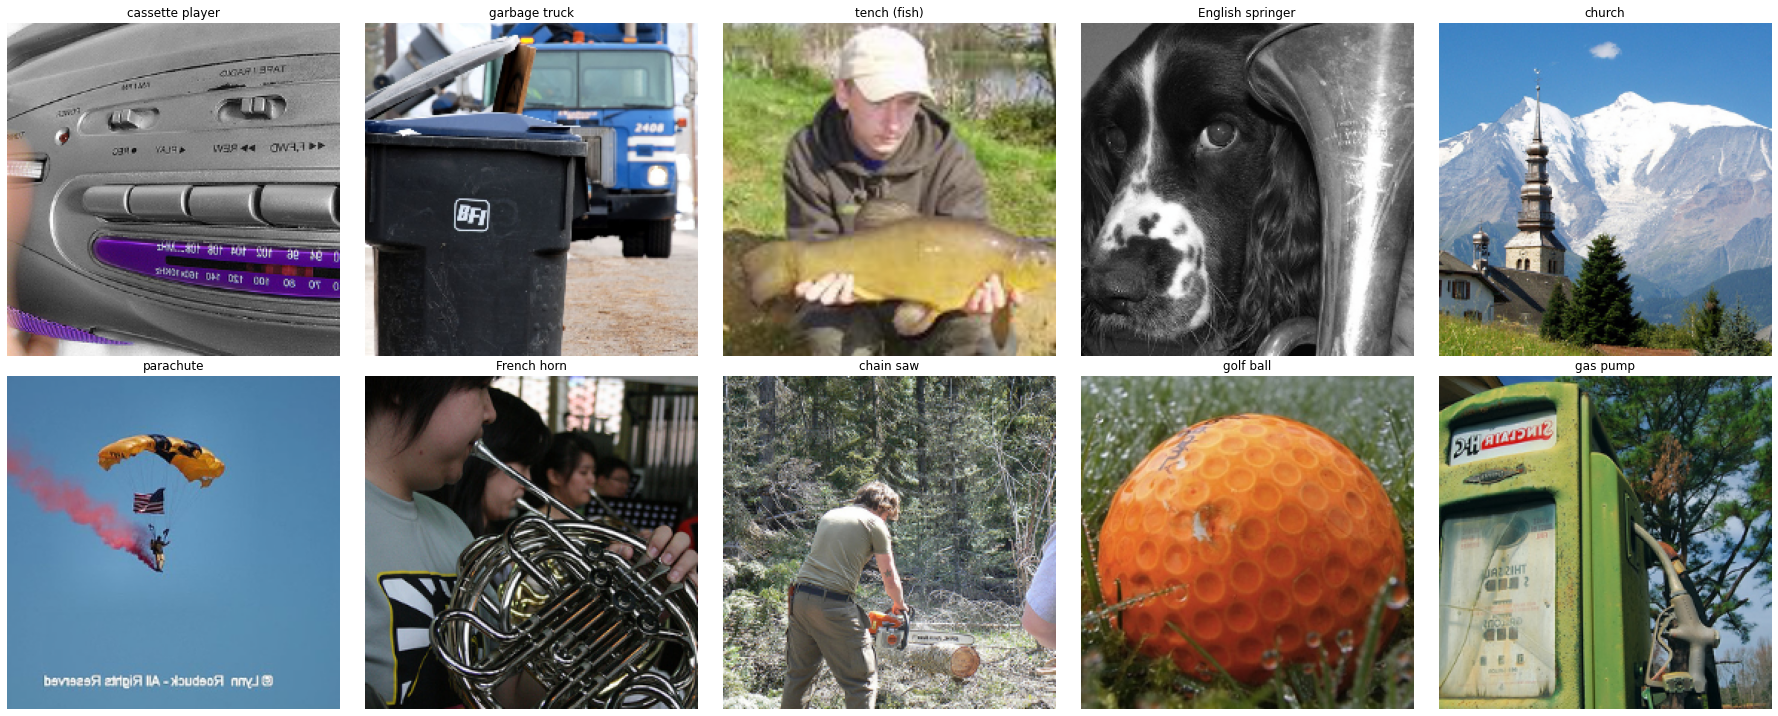

In [45]:
# Test custom class
w, h, s = 5, 2, 5
fig, axs = plt.subplots(h, w, figsize=(w*s, h*s))
axs = axs.ravel()

# imgs_idxs = np.random.choice(len(train_dataset), len(axs), replace=False)

for i in range(len(axs)):
    img, label = train_dataset[first_img_per_class[i]]

    axs[i].set_title(num_labels_map[np.argmax(label.numpy())])
    axs[i].axis('off')
    axs[i].imshow(plot_image(img))
       
plt.tight_layout()
plt.show()

In [ ]:
# more compact version of common Imagenet preprocessing stepsx
data_transforms_short = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

## Load Dataset with DataLoaders

In [46]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

fixing grayscale
fixing grayscale
Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64, 10])


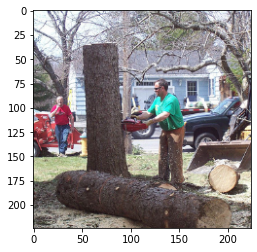

Label: chain saw


In [50]:
# Check Training Dataloader
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = num_labels_map[np.argmax(train_labels[0].numpy())]
plt.imshow(plot_image(img))
plt.show()
print(f"Label: {label}")

fixing grayscale
fixing grayscale
fixing grayscale
Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64, 10])


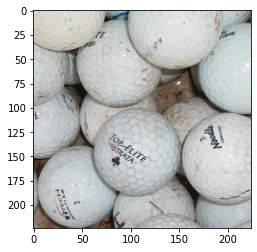

Label: golf ball


In [52]:
# Check Testing Dataloader
test_features, test_labels = next(iter(test_dataloader))
print(f"Feature batch shape: {test_features.size()}")
print(f"Labels batch shape: {test_labels.size()}")
img = test_features[0].squeeze()
label = num_labels_map[np.argmax(test_labels[0].numpy())]
plt.imshow(plot_image(img))
plt.show()
print(f"Label: {label}")